## Task 2

In [2]:
using Yao
using Yao.ConstGate # needed for P1 = 0.5*(I - sigma_z) block
using FreqTables
using LightGraphs
using GraphPlot
using Compose
using Colors
using Plots
using PyCall

In [3]:
#!/usr/bin/env julia


#=
H(t) = Ω(t) ∑_i σ_i^x - δ(t) ∑_i n_i + u ∑_ij n_i n_j
=#

const u = 1.35
const Ω_max = 1.89
const δ_0 = -1.0
const δ_max = 1.0

function get_edges(graph::Vector{NTuple{2, Float64}})
    Nv = size(graph)[1]
    edges = falses(Nv, Nv)
    for i in 1:(Nv-1)
        xi, yi = graph[i]
        for j in (i+1):Nv
            xj, yj = graph[j]

            dij = sqrt((xi - xj)^2. + (yi - yj)^2.)
            if dij <= 1.0
                edges[i,j] = true
            end
        end
    end
    return findall(edges)
end

function Ω(t::Float64)
    if 0 <= t <= 0.25
        return (Ω_max / 0.25) * t
    elseif 0.25 < t <= 0.69
        return Ω_max
    elseif 0.69 < t <= 1
        return - Ω_max * t / 0.31 + Ω_max * (1 + 0.69/0.31)
    end
end

function δ(t::Float64)
    slope = (δ_0 - δ_max)/(0.25 - 0.69)
    if 0 <= t <= 0.25
        return δ_0
    elseif 0.25 < t <= 0.69
        return t * slope + (δ_max - slope * 0.69)
    elseif 0.69 < t <= 1
        return δ_max
    end
end 

function hamiltonian(graph::Vector{NTuple{2, Float64}}, edges::Vector{CartesianIndex{2}}, t::Float64)
    # the UD-MIS Hamiltonian
    Nv = size(graph)[1] # number of vertices

    interaction_term = map(1:size(edges)[1]) do i
        l,m = edges[i][1], edges[i][2]
        repeat(Nv,u*P1,(l,m))
    end |> sum
    interaction_term - δ(t)*sum(map(i->put(Nv,i=>P1), 1:Nv)) + Ω(t)*sum(map(i->put(Nv,i=>X), 1:Nv))
end

function run_annealing(graph::Vector{NTuple{2, Float64}}, edges::Vector{CartesianIndex{2}}, dt::Float64)
    psi_t = zero_state(size(graph)[1])
    for t in 0:dt:1.0
        h = hamiltonian(graph, edges, t)
        psi_t = psi_t |> TimeEvolution(h, dt * 100)
    end
    return psi_t
end

run_annealing (generic function with 1 method)

In [4]:
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]
edges = get_edges(graph)
dt = 0.001
psi = run_annealing(graph, edges, dt)

ArrayReg{1, ComplexF64, Array...}
    active qubits: 6/6

In [5]:
samples  = measure(psi; nshots = 100_000)
list_top = sort(freqtable(samples), rev = true)[1:5]

5-element Named Vector{Int64}
Dim1       │ 
───────────┼──────
011100 ₍₂₎ │ 28525
110100 ₍₂₎ │ 28418
010101 ₍₂₎ │ 28410
110101 ₍₂₎ │  2976
011101 ₍₂₎ │  2907

In [6]:
top_five = names(list_top)[1]

5-element Vector{BitBasis.BitStr64{6}}:
 011100 ₍₂₎
 110100 ₍₂₎
 010101 ₍₂₎
 110101 ₍₂₎
 011101 ₍₂₎

In [7]:
top_solution    = top_five[1]
second_solution = top_five[2]
third_solution  = top_five[3]
fourth_solution = top_five[4]
fifth_solution  = top_five[5]

011101 ₍₂₎

In [8]:
sizeof(top_solution)

8

In [9]:
# Reconfigure Endianess
# using BitBasis
# corr = BitBasis.breflect(top_solution)

In [10]:
x_coords, y_coords = Float64[], Float64[]
for element in graph
    push!(x_coords, element[1])
    push!(y_coords, element[2])
end

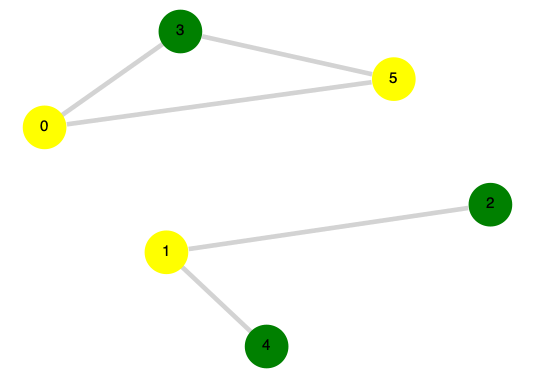

In [30]:
using Cairo, Compose

g = Graph(6)

for edge in edges
    add_edge!(g, edge[1], edge[2])
end

nodefillc = []
for i in top_solution
   i != 1 ? push!(nodefillc, colorant"yellow") : push!(nodefillc, colorant"green")
end

gplot(g, x_coords, y_coords, nodelabel = [i for i in 0:5], nodefillc = nodefillc, edgestrokec=colorant"lightgray")

## Gotham Tower

In [28]:
gotham_graph = [(1.19, 4.25), 
                (2.71, 3.48), 
                (1.19, 3.51), 
                (2.0,3.38), 
                (1.12, 2.86), 
                (1.70, 2.42),
                (2.36, 2.54),
                (1.52, 1.48),
                (2.15, 1.54),
                (2.14, 1.87),
                (1.72, 0.86),
                (2.29, 0.87)]

gotham_x_coords, gotham_y_coords = Float64[], Float64[]

for element in gotham_graph
    push!(gotham_x_coords, element[1])
    push!(gotham_y_coords, element[2])
end

gotham_edges = get_edges(gotham_graph)
gotham_dt = 0.001
gotham_psi = run_annealing(gotham_graph, gotham_edges, gotham_dt)

ArrayReg{1, ComplexF64, Array...}
    active qubits: 12/12

In [29]:
gotham_samples  = measure(gotham_psi; nshots = 100_000)
gotham_list_top = sort(freqtable(gotham_samples), rev = true)[1:5]

5-element Named Vector{Int64}
Dim1             │ 
─────────────────┼──────
100001010011 ₍₂₎ │ 17615
010001010011 ₍₂₎ │ 17537
011000010011 ₍₂₎ │ 12333
101000010011 ₍₂₎ │ 12330
000011010011 ₍₂₎ │  9716

In [31]:
gotham_top_solution = names(gotham_list_top)[1][1]

100001010011 ₍₂₎

In [32]:
gotham_edges

19-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 3)
 CartesianIndex(2, 4)
 CartesianIndex(3, 4)
 CartesianIndex(3, 5)
 CartesianIndex(5, 6)
 CartesianIndex(4, 7)
 CartesianIndex(6, 7)
 CartesianIndex(6, 8)
 CartesianIndex(6, 9)
 CartesianIndex(8, 9)
 CartesianIndex(6, 10)
 CartesianIndex(7, 10)
 CartesianIndex(8, 10)
 CartesianIndex(9, 10)
 CartesianIndex(8, 11)
 CartesianIndex(9, 11)
 CartesianIndex(8, 12)
 CartesianIndex(9, 12)
 CartesianIndex(11, 12)

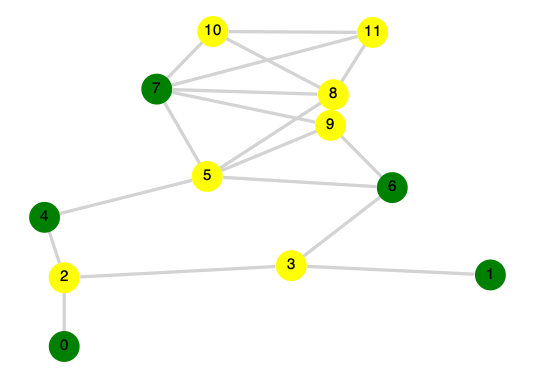

In [61]:
gotham_g = Graph(12)

for edge in gotham_edges
    add_edge!(gotham_g, edge[1], edge[2])
end

nodefillc = []
for i in names(gotham_list_top)[1][5]
   i != 1 ? push!(nodefillc, colorant"yellow") : push!(nodefillc, colorant"green")
end

draw(PNG("5.png", 16cm, 16cm), gplot(gotham_g, gotham_x_coords, gotham_y_coords, nodefillc = nodefillc, edgestrokec=colorant"lightgray",nodelabel = [i for i in 0:11]))
gplot(gotham_g, gotham_x_coords, gotham_y_coords, nodefillc = nodefillc, edgestrokec=colorant"lightgray",nodelabel = [i for i in 0:11])

In [17]:
size(gotham_graph)[1]

12

## Benchmark 

In [29]:
edges = get_edges(graph)
elapsedTime = @elapsed run_annealing(graph, edges, dt)
println("Time to run simple problem: ", elapsedTime)

Time to run simple problem: 1.7254484


In [30]:
elapsedTime = @elapsed run_annealing(gotham_graph, gotham_edges, dt)
println("Time to run Gotham sim: ", elapsedTime)

Time to run Gotham sim: 106.2549618


In [25]:
rand_tuple_point()  = (rand(), rand()) # note the ()
Nlist = [5, 6, 7, 8, 9, 10]
elapsedTimeList = Float64[]
for N in Nlist
    println("N: ", N)
    tmp = 0.0
    for _ in 1:3 # Repeat 3 times

        graphRand  = [rand_tuple_point()  for _ in 1:N] # create vectors of N random points each
        edges = get_edges(graphRand)
        dt = 0.001
        t1 = time_ns()
        psi = run_annealing(graphRand, edges, dt)
        t2 = time_ns()
        elapsedTime = (t2-t1)/1.0e9
        println(elapsedTime)
        println(" ")
        tmp = tmp+elapsedTime/3
    end
    push!(elapsedTimeList,tmp)
end

N: 5
0.5154837
 
0.4920262
 
0.4896522
 
N: 6
2.6267624
 
2.6110573
 
0.7283561
 
N: 7
2.6432279
 
2.7858699
 
2.716245
 
N: 8
7.1646376
 
7.2967983
 
8.3357578
 
N: 9
18.4302204
 
20.0672863
 
17.8709222
 
N: 10
40.4326713
 
38.9844169
 
39.2116646
 


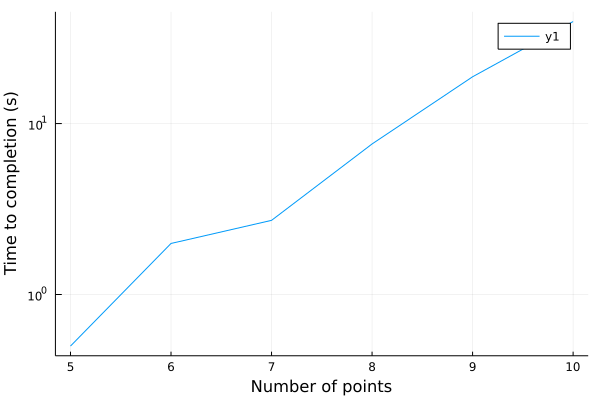

In [26]:
plot(Nlist,elapsedTimeList, yaxis=:log)
xlabel!("Number of points")
ylabel!("Time to completion (s)")